In [1]:
import torch
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import numpy as np

from ltn_imp.automation.data_loaders import LoaderWrapper
from ltn_imp.automation.knowledge_base import KnowledgeBase

## Dataset Preparation

In [2]:
!poetry run poe download-datasets

Poe => mkdir -p examples/datasets
Poe => curl -L -o examples/datasets/iris_training.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_training.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0   7595      0 --:--:-- --:--:-- --:--:--  7621
Poe => curl -L -o examples/datasets/iris_test.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_test.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598  100   598    0     0  11496      0 --:--:-- --:--:-- --:--:-- 11725
Poe => curl -L -o examples/datasets/real_estate.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/real-estate.csv
  % Total    % Received % Xferd  Average Spee

In [3]:
data = pd.read_csv("datasets/real_estate.csv")
data = data.sample(frac=1)  # shuffle

x = torch.tensor(data[['X1 transaction date', 'X2 house age',
                     'X3 distance to the nearest MRT station',
                     'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']].to_numpy()).float()

y = torch.tensor(data[['Y house price of unit area']].to_numpy()).float()

x_train, y_train = x[:330], y[:330]
x_test, y_test = x[330:], y[330:]

In [4]:
class DataLoader(object):
    def __init__(self,
                 x,
                 y,
                 batch_size=1,
                 shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.x.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.x.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            x = self.x[idxlist[start_idx:end_idx]]
            y = self.y[idxlist[start_idx:end_idx]]

            yield x, y

# create train and test loader
train_loader = DataLoader(x_train, y_train, 64, shuffle=True)
test_loader = DataLoader(x_test, y_test, 64, shuffle=False)

## Models

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes=(6, 8, 8, 1)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x):
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        out = self.linear_layers[-1](x)
        return out
    
    def compute_rmse(self, loader):
        mean_rmse = 0.0
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            for x, y in loader:
                predictions = self(x).squeeze().detach().numpy()  # Get predictions
                y = y.detach().numpy()  # Convert y to numpy
                mean_rmse += root_mean_squared_error(y, predictions)
        self.train()
        return mean_rmse / len(loader)

## Logic Rules and Optimization

In [6]:
model = MLP()

In [7]:
model.compute_rmse(train_loader)

np.float32(106.11712)

In [8]:
model.compute_rmse(test_loader)

np.float32(108.120895)

In [9]:
loader = LoaderWrapper(loader=train_loader, variables=["x"], targets=["y"])

expression = "forall x. (y = Regressor(x))"

predicates = {"Regressor": model}

connective_impls = {"eq": "sqrt"}

quantifier_impls = {"forall": "pmean_error"}

rule_to_loader_mapping = {expression: [loader]}

kb = KnowledgeBase(learning_rules=[expression],ancillary_rules=[], predicates=predicates, quantifier_impls=quantifier_impls,connective_impls=connective_impls, 
                   rule_to_data_loader_mapping=rule_to_loader_mapping)

In [10]:
kb.optimize(num_epochs=601, log_steps=100, lr=0.0005)

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.0422, grad_fn=<RsubBackward1>)]
Epoch 1/601, Loss: 0.9578059315681458

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7610, grad_fn=<RsubBackward1>)]
Epoch 101/601, Loss: 0.23901039361953735

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7739, grad_fn=<RsubBackward1>)]
Epoch 201/601, Loss: 0.22608500719070435

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7810, grad_fn=<RsubBackward1>)]
Epoch 301/601, Loss: 0.21902751922607422

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7826, grad_fn=<RsubBackward1>)]
Epoch 401/601, Loss: 0.21735751628875732

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7832, grad_fn=<RsubBackward1>)]
Epoch 501/601, Loss: 0.21679550409317017

['all x.(y = Regressor(x))']
Rule Outputs:  [tensor(0.7844, grad_fn=<RsubBackward1>)]
Epoch 601/601, Loss: 0.2156352996826172



In [11]:
model.compute_rmse(train_loader)

np.float32(8.461211)

In [12]:
model.compute_rmse(test_loader)

np.float32(6.709422)

## Computation Graph

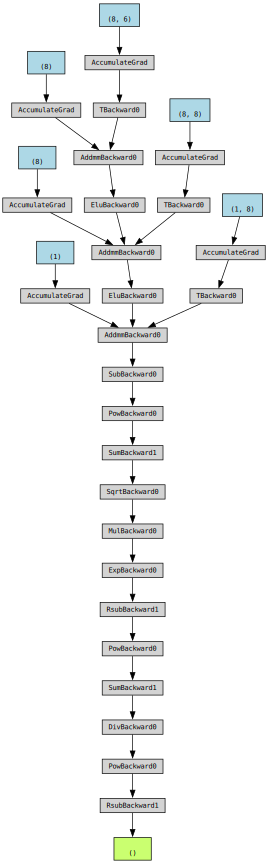

In [13]:
batch = next(iter(test_loader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader )

kb.rules[0].comp_graph(var_mapping)